###  objectives

In this lab, you learn about the following techniques for reducing 
BigQuery execution times and costs:
•Minimizing I/O
•Caching results of previous queries
•Performing efficient joins
•Avoid over-whelming single workers
•Using approximate aggregation functions

### Minimize I/O
A query that computes the sum of three columns will be slower than a query that computes the sum of two 
columns, but most of the performance difference will be due to reading more data, not the extra addition. Therefore, 
a query that computes the mean of a column will be nearly as fast as a query whose aggregation method is to 
compute the variance of the data (even though computing variance requires BigQuery to keep track of both the sum 
and the sum of the squares) because most of the overhead of simple queries is caused by I/O, not by computation.
Be purposeful in SELECT
Because BigQuery uses columnar file formats, the fewer the columns that are read in a SELECT, the less the amount 
of data that needs to be read. In particular, doing a SELECT * reads every column of every row in the table, making it 
quite slow and expensive. The exception is when you use a SELECT * in a subquery, then only reference a few fields 
in an outer query; the BigQuery optimizer will be smart enough to only read the columns that are absolutely required.


In [ ]:
SELECT
bike_id,
duration
FROM
`bigquery-public-data`.london_bicycles.cycle_hire
ORDER BY
duration DESC
LIMIT 1
-- In the Query results window notice that the 
-- query completed in ~1.2s and processed 
-- ~372MB of data.

In [ ]:
SELECT * FROM `bigquery-public-data`.london_bicycles.cycle_hire
ORDER BY duration DESC LIMIT 1

-- In the Query results window notice that this 
-- query completed in ~4.5s and consumed 
-- ~2.6GB of data. Much longer!


### Reduce data being read
When tuning a query, it is important to start with the data that is being read and consider whether it is possible to 
reduce this. Suppose we wish to find the typical duration of the most common one-way rentals.
1.Execute the following query into the BigQuery editor window:
2.Click on the Execution details tab of the Query results window

In [ ]:
SELECT
MIN(start_station_name) AS start_station_name,
MIN(end_station_name) AS end_station_name,
APPROX_QUANTILES(duration, 10)[OFFSET (5)] AS 
typical_duration,
COUNT(duration) AS num_trips
FROM
`bigquery-public-data`.london_bicycles.cycle_hire
WHERE
start_station_id != end_station_id
GROUP BY
start_station_id,
end_station_id
ORDER BY
num_trips DESC
LIMIT
10

We can reduce the I/O overhead of the query if we do the filtering and grouping using the 
station name rather than the station id since we will need to read fewer columns.

In [ ]:
SELECT
start_station_name,
end_station_name,
APPROX_QUANTILES(duration, 10)[OFFSET(5)] AS 
typical_duration,
COUNT(duration) AS num_trips
FROM
`bigquery-public-data`.london_bicycles.cycle_hire
WHERE
start_station_name != end_station_name
GROUP BY
start_station_name,
end_station_name
ORDER BY
num_trips DESC
LIMIT
10


The above query avoids the need to read the two id 
columns and finishes in 10.8 seconds. This speedup is 
caused by the downstream effects of reading less data

### Reduce number of expensive computations
Suppose we wish to find the total distance traveled by each bicycle in our dataset.
1.A naive way to do this would be to find the distance traveled in each trip undertaken by each 
bicycle and sum them up:

In [ ]:
WITH
trip_distance AS (
SELECT
bike_id,
ST_Distance(ST_GeogPoint(s.longitude,
s.latitude),
ST_GeogPoint(e.longitude,
e.latitude)) AS distance
FROM
`bigquery-public-data`.london_bicycles.cycle_hire,
`bigquery-public-data`.london_bicycles.cycle_stations s,
`bigquery-public-data`.london_bicycles.cycle_stations e
WHERE
start_station_id = s.id
AND end_station_id = e.id )
SELECT
bike_id,
SUM(distance)/1000 AS total_distance
FROM
trip_distance
GROUP BY
bike_id
ORDER BY
total_distance DESC
LIMIT 5

This query takes 9.8 seconds (55 seconds 
of slot time) and shuffles 1.22 MB. The 
result is that some bicycles have been 
ridden nearly 6000 kilometers

Computing the distance is a pretty expensive 
operation and we can avoid joining 
the cycle_stations table against the cycle_hire
table if we precompute the distances between 
all pairs of stations:


In [ ]:
WITH
stations AS (
SELECT
s.id AS start_id,
e.id AS end_id,
ST_Distance(ST_GeogPoint(s.longitude,
s.latitude),
ST_GeogPoint(e.longitude,
e.latitude)) AS distance
FROM
`bigquery-public-data`.london_bicycles.cycle_stations s,
`bigquery-public-data`.london_bicycles.cycle_stations e ),
trip_distance AS (
SELECT
bike_id,
distance
FROM
`bigquery-public-data`.london_bicycles.cycle_hire,
stations
WHERE
start_station_id = start_id
AND end_station_id = end_id )
SELECT
bike_id,
SUM(distance)/1000 AS total_distance
FROM
trip_distance
GROUP BY
bike_id
ORDER BY
total_distance DESC
LIMIT 5

This query only makes 600k geo-distance 
calculations vs. 24M previously. Now it takes 
31.5 seconds of slot time (a 30% speedup), 
despite shuffling 33.05MB of data


### Cache results of previous queries
The BigQuery service automatically caches query results in a temporary table. If the identical query is 
submitted within approximately 24 hours, the results are served from this temporary table without any 
recomputation. Cached results are extremely fast and do not incur charges.
There are, however, a few caveats to be aware of. Query caching is based on exact string comparison. So 
even whitespaces can cause a cache miss. Queries are never cached if they exhibit non-deterministic 
behavior (for example, they use CURRENT_TIMESTAMP or RAND), if the table or view being queried has 
changed (even if the columns/rows of interest to the query are unchanged), if the table is associated with a 
streaming buffer (even if there are no new rows), if the query uses DML statements, or queries external data 
sources.
### Cache intermediate results
It is possible to improve overall performance at the expense of increased I/O by taking advantage of 
temporary tables and materialized views.
1.For example, suppose you have a number of queries that start out by finding the typical duration of trips 
between a pair of stations. The WITH clause (also called a Common Table Expression) improves readability 
but does not improve query speed or cost since results are not cached. The same holds for views and 
subqueries as well. If you find yourself using a WITH clause, view, or a subquery often, one way to potentially 
improve performance is to store the result into a table (or materialized view).
First you will need to create a dataset named mydataset in the eu (multiple regions in European Union) region 
(where the bicycle data resides) under your project in BigQuery.
•In the left pane in the Explorer section, click on the View action icon (three dots) near your BigQuery project 
(qwiklabs-gcp-xxxx) and select Create dataset. (mydataset)


In [ ]:
-- Cache intermediate results

CREATE OR REPLACE TABLE
mydataset.typical_trip AS
SELECT
start_station_name,
end_station_name,
APPROX_QUANTILES(duration, 10)[OFFSET (5)] AS 
typical_duration,
COUNT(duration) AS num_trips
FROM
`bigquery-public-data`.london_bicycles.cycle_hire
GROUP BY
start_station_name,
end_station_name


In [ ]:
-- 2.Use the table created to find days when bicycle trips are much longer than usual:
SELECT
EXTRACT (DATE
FROM
start_date) AS trip_date,
APPROX_QUANTILES(duration / typical_duration, 10)[OFFSET(5)] AS 
ratio,
COUNT(*) AS num_trips_on_day
FROM
`bigquery-public-data`.london_bicycles.cycle_hire AS hire
JOIN
mydataset.typical_trip AS trip
ON
hire.start_station_name = trip.start_station_name
AND hire.end_station_name = trip.end_station_name
AND num_trips > 10
GROUP BY
trip_date
HAVING
num_trips_on_day > 10
ORDER BY
ratio DESC
LIMIT
10


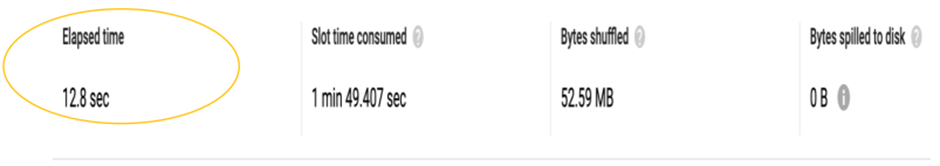

In [ ]:
WITH
typical_trip AS (
SELECT
start_station_name,
end_station_name,
APPROX_QUANTILES(duration, 10)[OFFSET (5)] AS typical_duration,
COUNT(duration) AS num_trips
FROM
`bigquery-public-data`.london_bicycles.cycle_hire
GROUP BY
start_station_name,
end_station_name )
SELECT
EXTRACT (DATE
FROM
start_date) AS trip_date,
APPROX_QUANTILES(duration / typical_duration, 10)[
OFFSET
(5)] AS ratio,
COUNT(*) AS num_trips_on_day
FROM
`bigquery-public-data`.london_bicycles.cycle_hire AS hire
JOIN
typical_trip AS trip
ON
hire.start_station_name = trip.start_station_name
AND hire.end_station_name = trip.end_station_name
AND num_trips > 10
GROUP BY
trip_date
HAVING
num_trips_on_day > 10
ORDER BY
ratio DESC
LIMIT
10

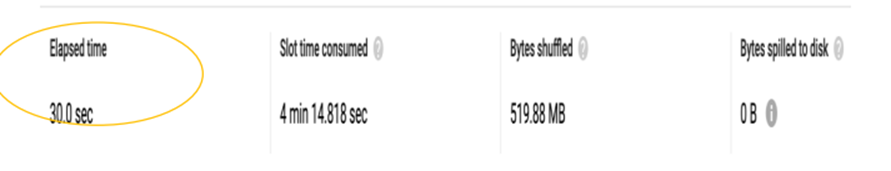

Notice the **~50% speedup** since the average trip duration 
computation is avoided. Both queries return the same 
result, that trips on Christmas take longer than usual. 
Note, the table mydataset.typical_trip is not refreshed when 
new data is added to the cycle_hire table. One way to solve 
this problem of stale data is to use a materialized view or 
to schedule queries to update the table periodically. You 
should measure the cost of such updates to see whether 
the improvement in query performance makes up for the 
extra cost of maintaining the table or materialized view upto-dat

### BI Engine
Accelerate queries with BI Engine
If there are tables that you access frequently in Business Intelligence (BI) settings such as 
dashboards with aggregations and filters, one way to speed up your queries is to employ BI 
Engine. It will automatically store relevant pieces of data in memory (either actual columns 
from the table or derived results), and will use a specialized query processor tuned for 
working with mostly in-memory data. You can reserve the amount of memory (up to a current 
maximum of 10 GB) that BigQuery should use for its cache from the BigQuery Admin Console, 
under BI Engine.
Make sure to reserve this memory in the same region as the dataset you are querying. Then, 
BigQuery will start to cache tables, parts of tables, and aggregations in memory and serve 
results faster.
A primary use case for BI Engine is for tables that are accessed from dashboard tools such 
as Google Data Studio. By providing memory allocation for a BI Engine reservation, we can 
make dashboards that rely on a BigQuery backend much more responsive.


### Efficient joins

Joining two tables requires data coordination and is subject to limitations imposed by the communication bandwidth between slots. If 
it is possible to avoid a join, or reduce the amount of data being joined, do so.
Denormalization
One way to improve the read performance and avoid joins is to give up on storing data efficiently, and instead add redundant copies 
of data. This is called denormalization.
1.Thus, instead of storing the bicycle station latitudes and longitudes separately from the cycle hire information, we could create a 
denormalized table:


In [ ]:
CREATE OR REPLACE TABLE
mydataset.london_bicycles_denorm AS
SELECT
start_station_id,
s.latitude AS start_latitude,
s.longitude AS start_longitude,
end_station_id,
e.latitude AS end_latitude,
e.longitude AS end_longitude
FROM
`bigquery-public-data`.london_bicycles.cycle_hire AS h
JOIN
`bigquery-public-data`.london_bicycles.cycle_stations AS s
ON
h.start_station_id = s.id
JOIN
`bigquery-public-data`.london_bicycles.cycle_stations AS e
ON
h.end_station_id = e.id


**important note** Then, all subsequent queries will not need to carry 
out the join because the table will contain the 
necessary location information for all trips. In this 
case, you are trading off storage and reading more 
data against the computational expense of a join. It 
is quite possible that the cost of reading more data 
from disk will outweigh the cost of the join -- you 
should measure whether denormalization brings 
performance benefits.

### Avoid self-joins of large tables
Self-joins happen when a table is joined with itself. While BigQuery supports self-joins, they can lead to performance 
degradation if the table being joined with itself is very large. In many cases, you can avoid the self-join by taking 
advantage of SQL features such as aggregation and window functions.
1.Let’s look at an example. One of the BigQuery public datasets is the dataset of baby names published by the US 
Social Security Administration. It is possible to query the dataset to find the most common male names in 2015 in 
the state of Massachusetts (Make sure your query is running in the us (multiple regions in United States) region by 
selecting More > Query settings > Additional settings > Data location):

In [ ]:
SELECT
name,
number AS num_babies
FROM
`bigquery-public-data`.usa_names.usa_1910_current
WHERE
gender = 'M'
AND year = 2015
AND state = 'MA'
ORDER BY
num_babies DESC
LIMIT
5


2.Similarly, query the dataset to find the most common 
female names in 2015 in the state of Massachusetts:
3.What are the most common names assigned to both male and female babies in the country over all the years in the dataset? A naive way to solve this 
problem involves reading the input table twice and doing a self-join:

In [ ]:
WITH
male_babies AS (
SELECT
name,
number AS num_babies
FROM
`bigquery-public-data`.usa_names.usa_1910_current
WHERE
gender = 'M' ),
female_babies AS (
SELECT
name,
number AS num_babies
FROM
`bigquery-public-data`.usa_names.usa_1910_current
WHERE
gender = 'F' ),
both_genders AS (
SELECT
name,
SUM(m.num_babies) + SUM(f.num_babies) AS num_babies,
SUM(m.num_babies) / (SUM(m.num_babies) + SUM(f.num_babies)) AS frac_male
FROM
male_babies AS m
JOIN
female_babies AS f
USING
(name)
GROUP BY
name )
SELECT
*
FROM
both_genders
WHERE
frac_male BETWEEN 0.3
AND 0.7
ORDER BY
num_babies DESC
LIMIT 5


To add insult to injury, the answer is also wrong -- as much as we like the name Jordan, the entire US population is 
only 300 million, so there cannot have been 982 million babies with that name. The self-JOIN unfortunately joins 
across state and year boundaries.
4.A faster, more elegant (and correct!) solution is to recast the query to read the input only once and avoid the selfjoin completely.

In [ ]:
WITH
all_babies AS (
SELECT
name,
SUM(
IF
(gender = 'M',
number,
0)) AS male_babies,
SUM(
IF
(gender = 'F',
number,
0)) AS female_babies
FROM
`bigquery-public-data.usa_names.usa_1910_current`
GROUP BY
name ),
both_genders AS (
SELECT
name,
(male_babies + female_babies) AS num_babies,
SAFE_DIVIDE(male_babies,
male_babies + female_babies) AS frac_male 
FROM
all_babies
WHERE
male_babies > 0
AND female_babies > 0 )
SELECT
*
FROM
both_genders
WHERE
frac_male BETWEEN 0.3
AND 0.7
ORDER BY
num_babies DESC
LIMIT
5


**This took only 2.4 seconds, a 30x speedup.**

### Reduce data being joined
It is possible to carry out the query above with an efficient join as long as we reduce the amount of data being joined by grouping the 
data by name and gender early on:

In [ ]:
WITH
all_names AS (
SELECT
name,
gender,
SUM(number) AS num_babies
FROM
`bigquery-public-data`.usa_names.usa_1910_current
GROUP BY
name,
gender ),
male_names AS (
SELECT
name,
num_babies
FROM
all_names
WHERE
gender = 'M' ),
female_names AS (
SELECT
name,
num_babies
FROM
all_names
WHERE
gender = 'F' ),
ratio AS (
SELECT
name,
(f.num_babies + m.num_babies) AS num_babies,
m.num_babies / (f.num_babies + m.num_babies) AS frac_male
FROM
male_names AS m
JOIN
female_names AS f
USING
(name) )
SELECT
*
FROM
ratio
WHERE
frac_male BETWEEN 0.3
AND 0.7
ORDER BY
num_babies DESC
LIMIT 5


The early grouping served to trim the data early in the query, 
before the query performs a JOIN. That way, shuffling and other 
complex operations only executed on the much smaller data and 
remain quite efficient. The query above finished in 2 seconds and 
returned the correct result.

### Use a window function instead of a self-join
Suppose you wish to find the duration between a bike being dropped off and it being rented again, i.e., the duration that 
a bicycle stays at the station. This is an example of a dependent relationship between rows. It might appear that the 
only way to solve this is to join the table with itself, matching the end_date of one trip against the start_date of the next. 
(Make sure your query is running in the eu (multiple regions in European Union) region by selecting More > Query 
settings > Additional settings > Data location)
1.You can, however, avoid a self-join by using a window function

In [ ]:
SELECT
bike_id,
start_date,
end_date,
TIMESTAMP_DIFF( start_date, LAG(end_date) OVER (PARTITION
BY bike_id ORDER BY start_date), SECOND) AS time_at_station
FROM
`bigquery-public-data`.london_bicycles.cycle_hire
LIMIT
5


Notice that the first row has a null for time_at_station since we don’t have a timestamp for the previous dropoff. After 
that, the time_at_station tracks the difference between the previous dropoff and the current pickup.
2.Using this, we can compute the average time that a bicycle is unused at each station and rank stations by that 
measure:


In [ ]:
WITH
unused AS (
SELECT
bike_id,
start_station_name,
start_date,
end_date,
TIMESTAMP_DIFF(start_date, LAG(end_date) OVER (PARTITION BY 
bike_id ORDER BY start_date), SECOND) AS time_at_station
FROM
`bigquery-public-data`.london_bicycles.cycle_hire )
SELECT
start_station_name,
AVG(time_at_station) AS unused_seconds
FROM
unused
GROUP BY
start_station_name
ORDER BY
unused_seconds ASC
LIMIT
5


### Join with precomputed values
Sometimes, it can be helpful to precompute functions on smaller tables, and then join with the precomputed values rather than
repeat an expensive calculation each time.
For example, suppose we wish to find the pair of stations between which our customers ride bicycles at the fastest pace. To 
compute the pace (minutes per kilometer) at which they ride, we need to divide the duration of the ride by the distance between 
stations.
1.We could create a denormalized table with distances between stations and then compute the average pace:


In [ ]:
WITH
denormalized_table AS (
SELECT
start_station_name,
end_station_name,
ST_DISTANCE(ST_GeogPoint(s1.longitude,
s1.latitude),
ST_GeogPoint(s2.longitude,
s2.latitude)) AS distance,
duration
FROM
`bigquery-public-data`.london_bicycles.cycle_hire AS h
JOIN
`bigquery-public-data`.london_bicycles.cycle_stations AS s1
ON
h.start_station_id = s1.id
JOIN
`bigquery-public-data`.london_bicycles.cycle_stations AS s2
ON
h.end_station_id = s2.id ),
durations AS (
SELECT
start_station_name,
end_station_name,
MIN(distance) AS distance,
AVG(duration) AS duration,
COUNT(*) AS num_rides
FROM
denormalized_table
WHERE
duration > 0
AND distance > 0
GROUP BY
start_station_name,
end_station_name
HAVING
num_rides > 100 )
SELECT
start_station_name,
end_station_name,
distance,
duration,
duration/distance AS pace
FROM durations
ORDER BY pace ASC
LIMIT 5


he above query invokes the geospatial function ST_DISTANCE once for each row in the cycle_hire table (24 million 
times), takes 14.7 seconds and processes 1.9 GB
2.Alternately, we can use the cycle_stations table to precompute the distance between every pair of stations (this is a 
self-join) and then join it with the reduced-size table of average duration between stations:


In [ ]:
WITH
distances AS (
SELECT
a.id AS start_station_id,
a.name AS start_station_name,
b.id AS end_station_id,
b.name AS end_station_name,
ST_DISTANCE(ST_GeogPoint(a.longitude,
a.latitude),
ST_GeogPoint(b.longitude,
b.latitude)) AS distance
FROM
`bigquery-public-data`.london_bicycles.cycle_stations a
CROSS JOIN
`bigquery-public-data`.london_bicycles.cycle_stations b
WHERE
a.id != b.id ),
durations AS (
SELECT
start_station_id,
end_station_id,
AVG(duration) AS duration,
COUNT(*) AS num_rides
FROM
`bigquery-public-data`.london_bicycles.cycle_hire
WHERE
duration > 0
GROUP BY
start_station_id,
end_station_id
HAVING
num_rides > 100 )
SELECT
start_station_name,
end_station_name,
distance,
duration,
duration/distance AS pace
FROM
distances
JOIN
durations
USING
(start_station_id,
end_station_id)
ORDER BYpace ASC
LIMIT 5


The recast query with the more efficient joins takes only 8.2
seconds, a 1.8x speedup and processes 554 MB, a nearly 4x 
reduction in cost.

### Avoid overwhelming a worker
Some operations (e.g. ordering) have to be carried out on a single worker. Having to sort too much data can overwhelm 
a worker’s memory and result in a “resources exceeded” error. Avoid overwhelming the worker with too much data. As 
the hardware in Google data centers is upgraded, what “too much” means in this context expands over time. Currently, 
this is on the order of one GB.
Limiting large sorts
1.Let’s say that we wish to go through the rentals and number them 1, 2, 3, etc. in the order that the rental ended. We 
could do that using the ROW_NUMBER() function

In [ ]:
SELECT
rental_id,
ROW_NUMBER() OVER(ORDER BY end_date) AS rental_number
FROM
`bigquery-public-data.london_bicycles.cycle_hire`
ORDER BY
rental_number ASC
LIMIT
5

t takes 34.5 seconds to process just 372 MB because it needs to sort the entirety of the London bicycles dataset on a single worker. 
Had we processed a larger dataset, it would have overwhelmed that worker.
2.We might want to consider whether it is possible to limit the large sorts and distribute them. Indeed, it is possible to extract the date 
from the rentals and then sort trips within each day:


In [ ]:
WITH
rentals_on_day AS (
SELECT
rental_id,
end_date,
EXTRACT(DATE
FROM
end_date) AS rental_date
FROM
`bigquery-public-data.london_bicycles.cycle_hire` )
SELECT
rental_id,
rental_date,
ROW_NUMBER() OVER(PARTITION BY rental_date ORDER BY end_date) 
AS rental_number_on_day
FROM
rentals_on_day
ORDER BY
rental_date ASC,
rental_number_on_day ASC
LIMIT
5

**This takes 15.1 seconds (a 2x speedup) because the 
sorting can be done on just a single day of data at a time.**

### Data skew
The same problem of overwhelming a worker (in this case, overwhelm the memory of the worker) can happen during 
an ARRAY_AGG with GROUP BY if one of the keys is much more common than the others.
1.Because there are more than 3 million GitHub repositories and the commits are well distributed among them, this 
query succeeds (make sure you execute the query in the us (multiple regions in United States) processing center):


In [ ]:
SELECT
repo_name,
ARRAY_AGG(STRUCT(author,
committer,
subject,
message,
trailer,
difference,
encoding)
ORDER BY
author.date.seconds)
FROM
`bigquery-public-data.github_repos.commits`,
UNNEST(repo_name) AS repo_name
GROUP BY
repo_name


Note, while this query will succeed, it can take upwards of 15 minutes to do so. If you understand the query, move on 
in the lab.
2.Most of the people using GitHub live in only a few time zones, so grouping by the timezone fails -- we are asking a 
single worker to sort a significant fraction of 750GB:


In [ ]:
SELECT
author.tz_offset,
ARRAY_AGG(STRUCT(author,
committer,
subject,
message,
trailer,
difference,
encoding)
ORDER BY
author.date.seconds)
FROM
`bigquery-public-data.github_repos.commits`
GROUP BY
author.tz_offset
-- can't query rows larger than 100MB

3.If you do require sorting all the data, use more granular keys (i.e. distribute the group’s data over more workers) 
and then aggregate the results corresponding to the desired key. For example, instead of grouping only by the 
time zone, it is possible to group by both timezone and repo_name and then aggregate across repos to get the 
actual answer for each timezone:

In [ ]:
SELECT
repo_name,
author.tz_offset,
ARRAY_AGG(STRUCT(author,
committer,
subject,
message,
trailer,
difference,
encoding)
ORDER BY
author.date.seconds)
FROM
`bigquery-public-data.github_repos.commits`,
UNNEST(repo_name) AS repo_name
GROUP BY
repo_name,
author.tz_offset


### Approximate aggregation functions
BigQuery provides fast, low-memory approximations of aggregate functions. Instead of using COUNT(DISTINCT …), we 
can use APPROX_COUNT_DISTINCT on large data streams when a small statistical uncertainty in the result is 
tolerable.
Approximate count
1.We can find the number of unique GitHub repositories using:

In [ ]:
SELECT
COUNT(DISTINCT repo_name) AS num_repos
FROM
`bigquery-public-data`.github_repos.commits,
UNNEST(repo_name) AS repo_name

The above query takes 8.3 seconds to compute the correct result of 3347770

In [ ]:
SELECT
APPROX_COUNT_DISTINCT(repo_name) AS num_repos
FROM
`bigquery-public-data`.github_repos.commits,
UNNEST(repo_name) AS repo_name


takes 3.9 seconds (a 2x speedup) and returns an approximate result of 3399473, which overestimates the correct 
answer by 1.5%.
The approximate algorithm is much more efficient than the exact algorithm only on large datasets and is 
recommended in use-cases where errors of approximately 1% are tolerable. Before using the approximate function, 
measure on your use case!
Other available approximate functions include APPROX_QUANTILES to compute percentiles, APPROX_TOP_COUNT to 
find the top elements and APPROX_TOP_SUM to compute top elements based on the sum of an element.

## clustering in bigquery

Clustering is a technique to group similar data points together in the same cluster. Clustering can be used to improve
performance and reduce cost in BigQuery. Clustering is a good fit for data that is accessed sequentially, filtered by one or
more columns, and grouped by one or more columns. Clustering is not a good fit for data that is updated frequently or
where the clustered columns have high cardinality (many distinct values). Clustering is also not a good fit for data that is
not accessed sequentially.

* Clustering : storage optimization within columnar segments to improve filtering and record colocation
* Clustering performance and cost saving can’t be assessed before query begin 
* Prioritized clustering of up to 4 columns, on more diverse types (but no nested columns )

When to use clustering 
•	Your data is already partitioned on DATE ot TIMESTAMP  OR interger Range
•	You commonly use filter ot aggregation against particular columns in your queries


